In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
import tensorflow as tf
from keras.applications import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
TRAIN_PATH = "./Training/"
TEST_PATH = "./Testing/"
img_width, img_height = 224, 224
channels = 3
batch_size = 64
num_images= 20
image_arr_size= img_width * img_height * channels
DPI = 900

In [3]:
def get_images(image_dir):
    image_index = 0
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = []

    if not os.path.exists(image_dir):
        print(f"Thư mục {image_dir} không tồn tại!")
        return None, None

    for type_folder in os.listdir(image_dir):
        type_path = os.path.join(image_dir, type_folder)

        if not os.path.isdir(type_path):
            continue

        labels.append(type_folder)

        type_images = os.listdir(type_path)
        for image in type_images[:5]:
            image_file = os.path.join(type_path, image)

            if not os.path.isfile(image_file):
                continue

            image_data = mpimg.imread(image_file)
            # Nếu ảnh grayscale (1 kênh), chuyển thành 3 kênh
            if image_data.ndim == 2:
                image_data = np.stack([image_data] * 3, axis=-1)

            image_resized = resize(image_data, (img_width, img_height, channels), mode='reflect', anti_aliasing=True)

            images[image_index, :] = image_resized.flatten()
            print(f"Đã load: {type_folder} - {image}")
            image_index += 1

    return images, np.array(labels)

def plot_images(instances, images_per_row=5, **options):
    size = img_width  # Định nghĩa kích thước ảnh
    images_per_row = min(len(instances), images_per_row)  # Số ảnh trên 1 hàng
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]  # Định hình ảnh
    n_rows = len(instances) // images_per_row  # Tính số hàng

    row_images = [
        np.concatenate(images[row * images_per_row:(row + 1) * images_per_row], axis=1)
        for row in range(n_rows)
    ]

    image = np.concatenate(row_images, axis=0)

    plt.figure(figsize=(20, 20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('brain_tumor_images.png', transparent=True, bbox_inches='tight', dpi=DPI)
    plt.show()

Đã load: glioma - Tr-glTr_0000.jpg
Đã load: glioma - Tr-glTr_0001.jpg
Đã load: glioma - Tr-glTr_0002.jpg
Đã load: glioma - Tr-glTr_0003.jpg
Đã load: glioma - Tr-glTr_0004.jpg
Đã load: meningioma - Tr-meTr_0000.jpg
Đã load: meningioma - Tr-meTr_0001.jpg
Đã load: meningioma - Tr-meTr_0002.jpg
Đã load: meningioma - Tr-meTr_0003.jpg
Đã load: meningioma - Tr-meTr_0004.jpg
Đã load: notumor - Tr-noTr_0000.jpg
Đã load: notumor - Tr-noTr_0001.jpg
Đã load: notumor - Tr-noTr_0002.jpg
Đã load: notumor - Tr-noTr_0003.jpg
Đã load: notumor - Tr-noTr_0004.jpg
Đã load: pituitary - Tr-piTr_0000.jpg
Đã load: pituitary - Tr-piTr_0001.jpg
Đã load: pituitary - Tr-piTr_0002.jpg
Đã load: pituitary - Tr-piTr_0003.jpg
Đã load: pituitary - Tr-piTr_0004.jpg


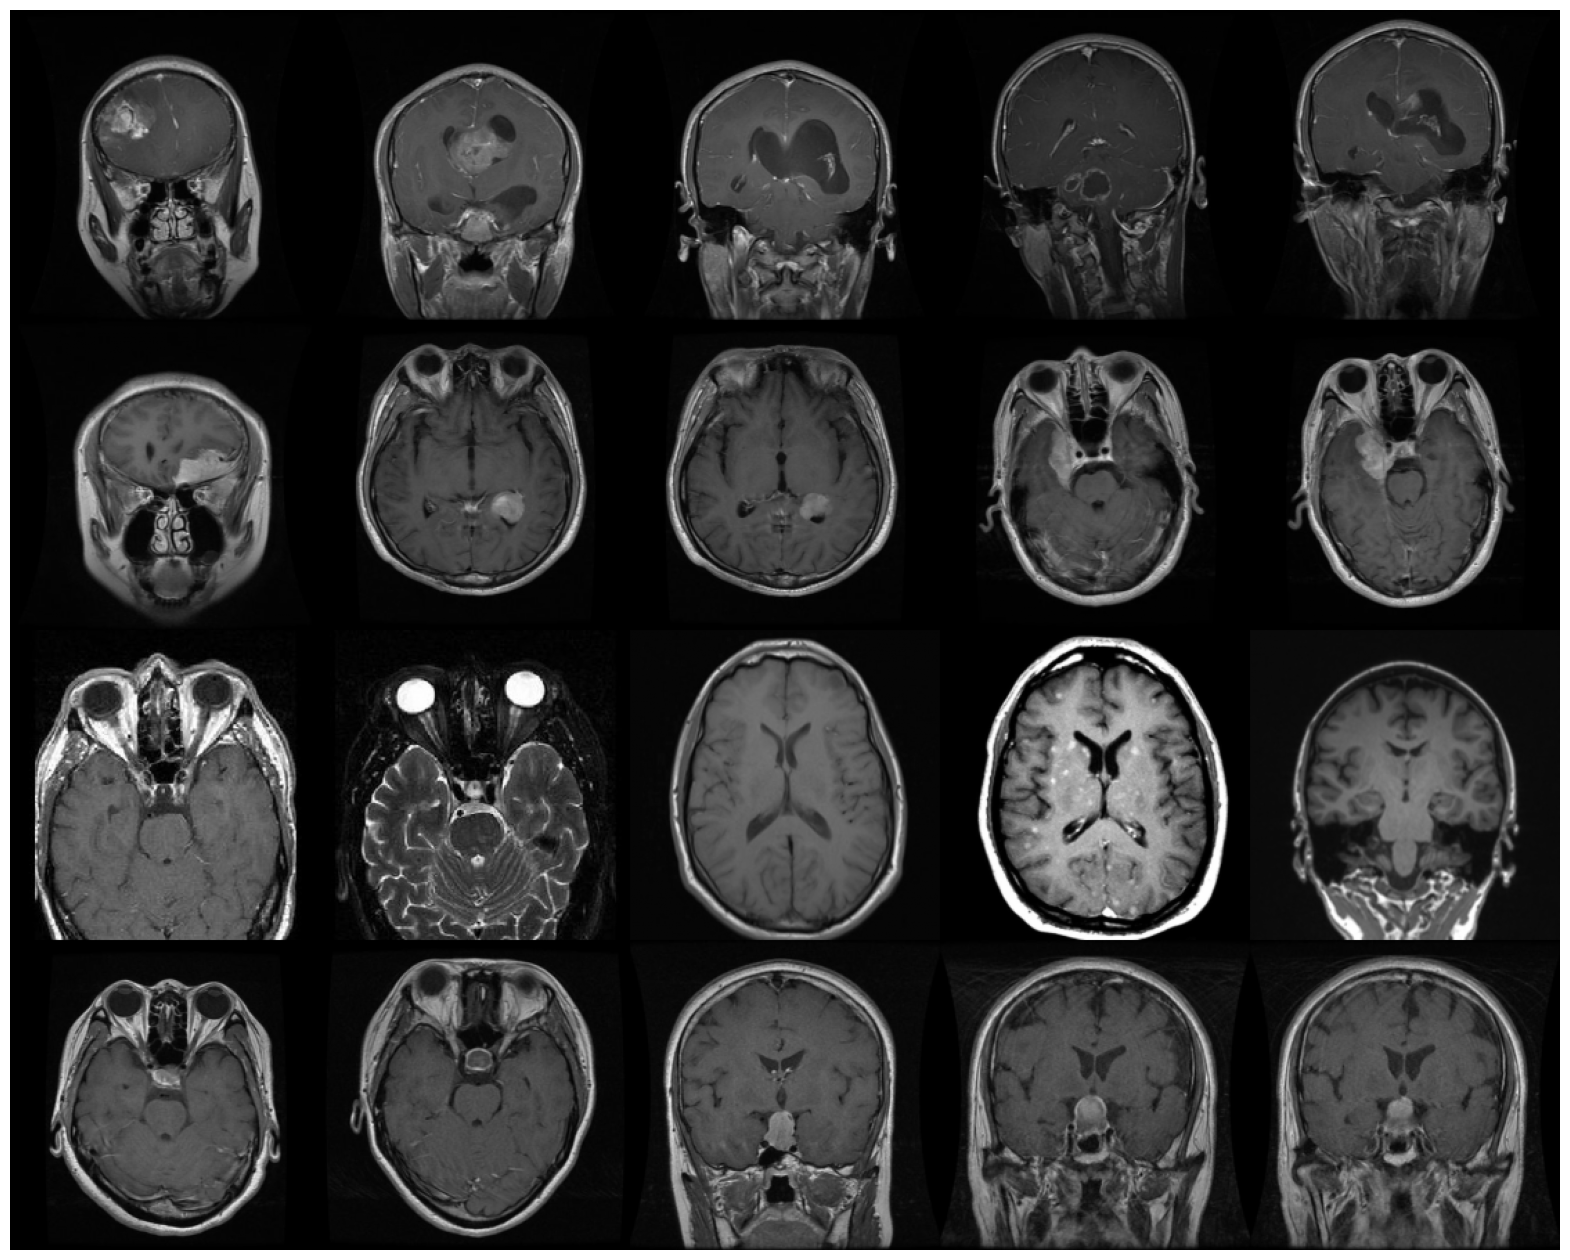

In [4]:
images, labels = get_images(TRAIN_PATH)
plot_images(images)

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 15,
    width_shift_range = 0.1,
    zoom_range = 0.01,
    shear_range = 0.01,
    brightness_range = [0.3, 1.5],
    horizontal_flip = True,
    vertical_flip = True
)
valid_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

valid_generator = valid_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

Found 5712 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [7]:
num_classes = len(train_generator.class_indices)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)
nb_valid_samples = len(valid_generator.filenames)

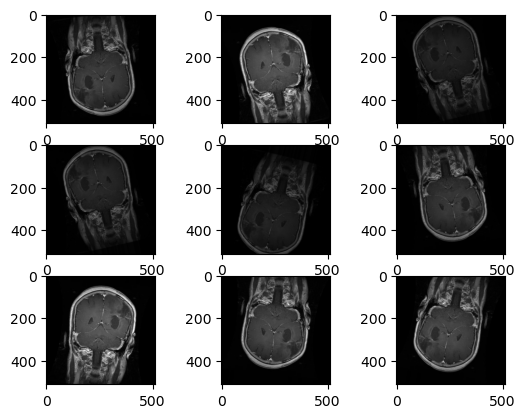

In [8]:
img = load_img(TRAIN_PATH + "glioma/Tr-gl_0010.jpg")
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.__next__()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= DPI)
plt.show()


In [9]:
base_model = InceptionV3(input_shape=(img_height, img_width, channels), weights='imagenet', include_top=False)
for layer in base_model.layers[:-30]:  # Giữ nguyên các layer đầu, chỉ fine-tune layer cuối
    layer.trainable = False

inputs = Input(shape=(img_height, img_width, channels))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 lớp đầu ra
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Thêm Dropout 30% nữa
x = Dense(4, activation='softmax')(x)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Theo dõi loss trên tập validation
    patience=10,  # Dừng nếu val_loss không giảm sau 10 epochs
    restore_best_weights=True,  # Lấy lại model tốt nhất
    min_delta=1e-4  # Chỉ dừng nếu giảm không đáng kể
)
lr_schedule = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=6, min_delta=0.0001)

callbacks = [early_stopping, lr_schedule]

In [11]:
model = Model(inputs, x)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,911,720 (91.22 MB)

 Trainable params: 7,263,944 (27.71 MB)

 Non-trainable params: 16,647,776 (63.51 MB)

In [12]:
history = model.fit(
    train_generator,
    epochs = 100,
    validation_data = valid_generator,
    verbose = 1,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/100


D:\Desktop\hocmay\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.5351 - loss: 13.7818 - val_accuracy: 0.3725 - val_loss: 11.4688 - learning_rate: 1.0000e-04
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.7899 - loss: 10.0116 - val_accuracy: 0.7730 - val_loss: 8.7590 - learning_rate: 1.0000e-04
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8628 - loss: 7.4886 - val_accuracy: 0.8983 - val_loss: 6.7700 - learning_rate: 1.0000e-04
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8948 - loss: 5.7796 - val_accuracy: 0.9387 - val_loss: 5.2211 - learning_rate: 1.0000e-04
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9146 - loss: 4.5452 - val_accuracy: 0.9018 - val_loss: 4.0926 - learning_rate: 1.0000e-04
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9305 - loss: 3.5866 - val_accuracy: 0.9562 - val_loss: 3.0835 - learning_rate: 1.0000e-04
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9339 - 

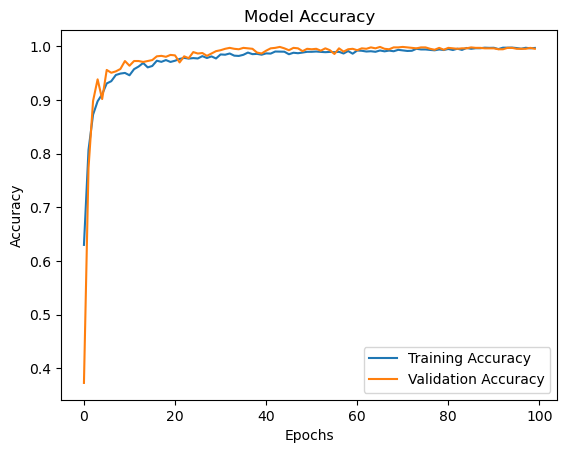

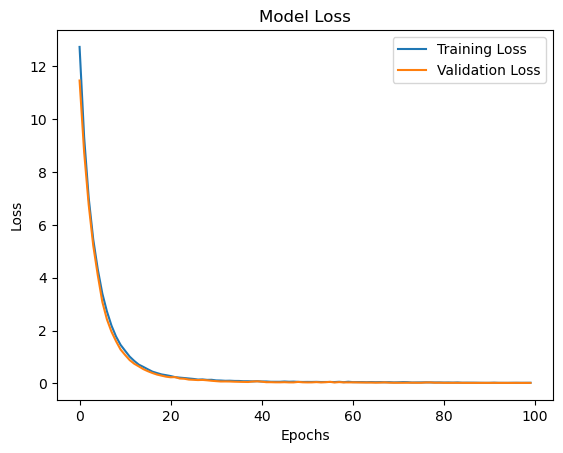

In [13]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= DPI)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= DPI)
plt.show()

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,         
    target_size=(224, 224),       
    batch_size=batch_size,
    class_mode='categorical',          
    shuffle=False                 
)
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

Found 1311 images belonging to 4 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9849 - loss: 0.0613


In [15]:
accuracy

0.989062488079071

In [18]:
model.save("braintumor_model.keras")